In [4]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import VBBinaryLensing
import pandas as pd
import scipy
import celerite
import emcee

mpl.rc('font',**{'family':'serif','serif':['Palatino']})
mpl.rc('text', usetex=True)
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['axes.titlesize'] = 16

%matplotlib inline

# Better looking figures
%config InlineBackend.figure_format = 'retina'

/home/fran/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


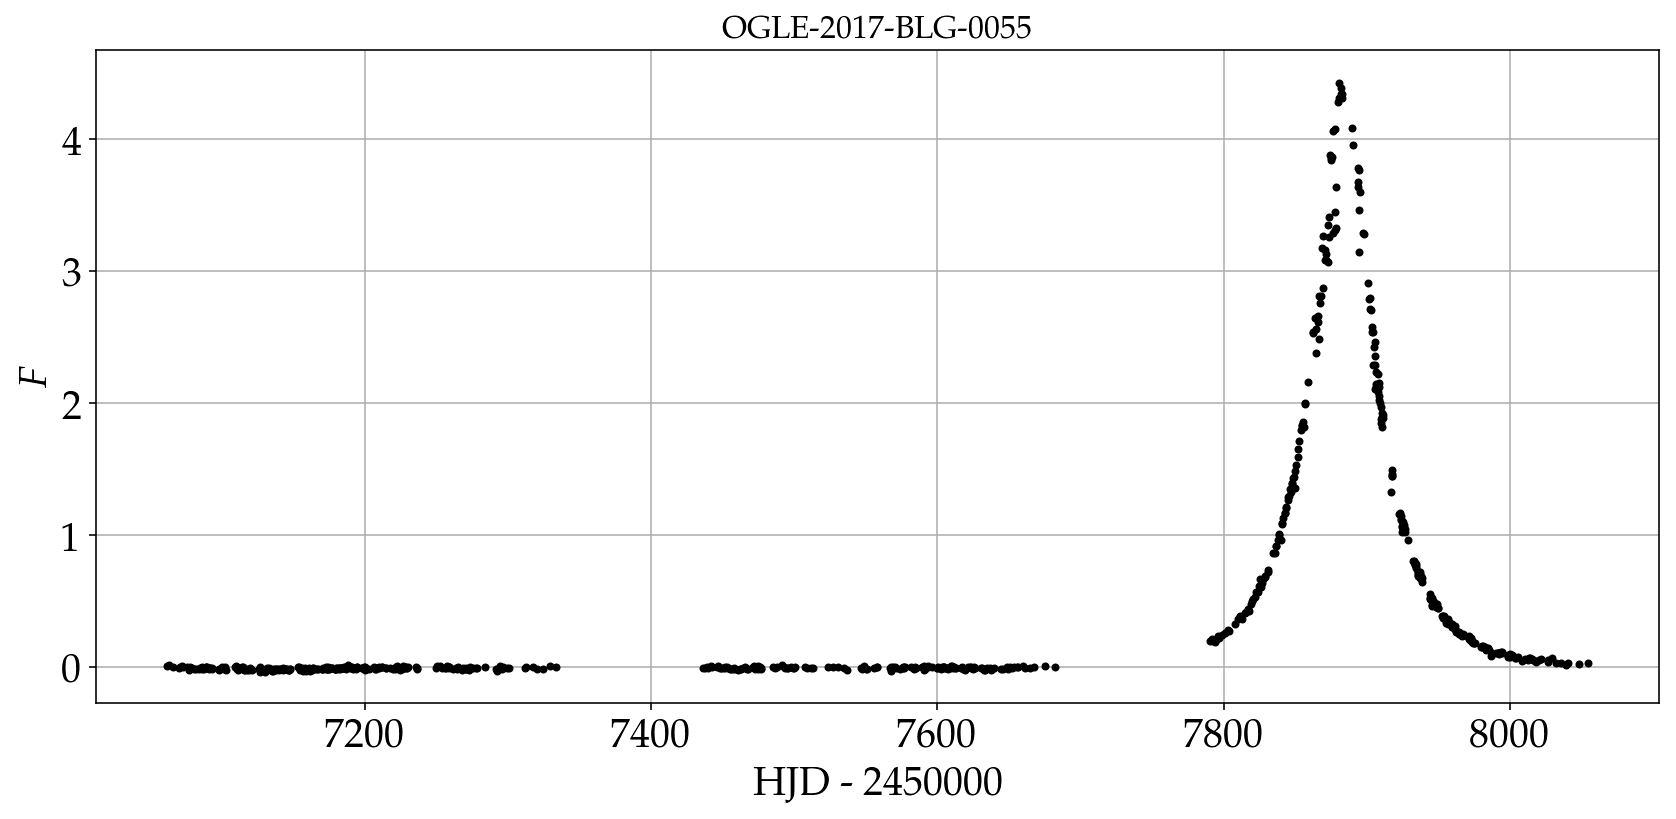

In [6]:
def load_data(path_to_data):
    data = pd.read_csv(path_to_data + '/phot.dat', 
                       names=['HJD', 'I_flux', 'I_flux_err', 'seeing_est', 'sky_level'],
                       delim_whitespace=True)

    # Magnitude zero point defined such that mag=22 corresponds to F=1
    mag_to_flux = lambda m: 10**(-(m - 22.)/2.5)
    magerr_to_fluxerr = lambda m, sigm: sigm*mag_to_flux(m)

    data['HJD'] -= 2450000
    data['I_flux_err'] = magerr_to_fluxerr(data['I_flux'].values, data['I_flux_err'].values)
    data['I_flux'] = mag_to_flux(data['I_flux'].values)

    # Subtract the median from the data such that baseline is at approx zero
    F = (data['I_flux'] - data['I_flux'].median())/np.std(data['I_flux'].values)
    sigF = data['I_flux_err']/np.std(data['I_flux'].values)
    
    return data['HJD'].values, F, sigF

def plot_data(ax, t, F, sigF):
    ax.errorbar(t, F, sigF, fmt='.', color='black', label='Data', ecolor='#686868')
    ax.grid(True)
    ax.set_xlabel('HJD - 2450000')
    ax.set_ylabel('$F$')
    ax.set_title('OGLE-2017-BLG-0055');

fig, ax = plt.subplots(figsize=(14,6))

t, F, sigF = load_data('../microlensing_data/OGLE/2017/blg-0055/') #714

plot_data(ax, t, F, sigF);

# Gaussian model

In [21]:
def pspl_flux(t, pars):
    Fs, Fb, t0, teff, tE = pars
    
    u0 = teff/tE

    u = np.sqrt(u0**2 + ((t - t0)/tE)**2)
    A = lambda u: (u**2 + 2)/(u*np.sqrt(u**2 + 4))

    return Fs*(A(u) - 1) + Fb

def log_likelihood(pars):

    N = len(F)

    dF = F - pspl_flux(t, pars)

    return np.sum(-0.5*dF**2/sigF**2)

def log_prior(pars):

    Fs, Fb, t0, teff, tE = pars

    if Fs < -10 or Fs > 5.:
        return -np.inf
    if Fb < -100 or Fb > 100:
        return -np.inf
    if t0 < np.min(t) or t0 > np.max(t): 
        return -np.inf
    if teff < 0. or teff > 10.:
        return -np.inf
    if tE < 0.5 or tE > 200.:
        return -np.inf

    return 0.

def log_posterior(pars):
    lnp = log_prior(pars)
    if np.isinf(lnp): # short-circuit if the prior is infinite (don't bother computing likelihood)
        return lnp

    lnL = log_likelihood(pars)
    lnprob = lnp + lnL

    if np.isnan(lnprob):
        return -np.inf

    return lnprob

In [7]:
t0_guess_idx = (np.abs(F - np.max(F))).argmin()

initial = [0., 0., t[t0_guess_idx], 0.5, 10.]

ndim, nwalkers = len(initial), 50
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)

print("Running burn-in...")
p0, _, _ = sampler.run_mcmc(p0, 1000)
sampler.reset()

print("Running production...")
sampler.run_mcmc(p0, 5000);

NameError: name 'log_posterior' is not defined

In [11]:
def plot_traceplots(sampler):
    n_pars = len(sampler.flatchain[0, :])
    fig, ax = plt.subplots(n_pars, sharex=True, figsize=(15,10))
    
    mask = sampler.acceptance_fraction > 0.01

    fig.subplots_adjust(hspace=0.08)

#     labels = [r'$F_S$', r'$F_B$',r'$t_0$',r'$u_0$',r'$t_E$']
    for i in range(n_pars):
        tmp = sampler.chain[mask, ::1, i].T
        ax[i].plot(np.arange(len(tmp)), tmp, 'k-', alpha=0.2);
#         ax[i].set_ylabel(labels[i])    

    for a in ax.ravel():
        a.grid(True)

    ax[-1].set_xlabel('steps')
    
plot_traceplots(sampler)

NameError: name 'sampler' is not defined

(7700, 8000)

/home/fran/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


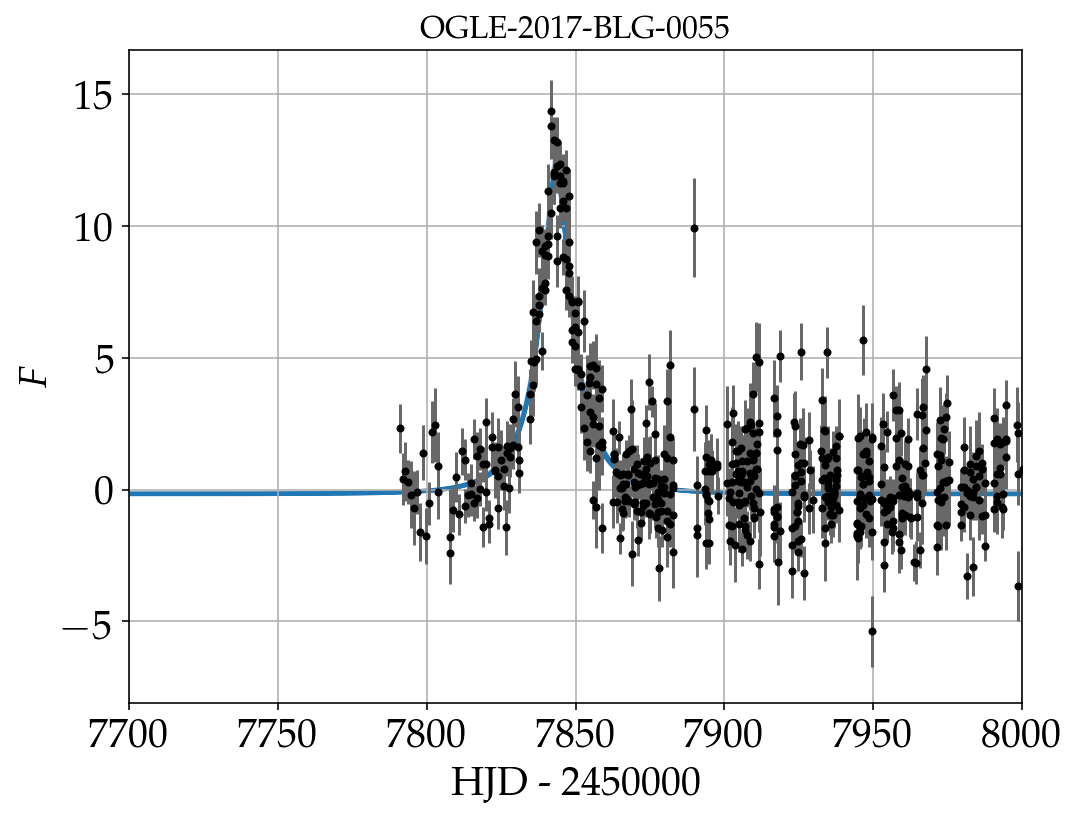

In [24]:
# Plot the data.
fig, ax = plt.subplots(figsize=(8, 6))

plot_data(ax, t, F, sigF)

t_ = np.linspace(t[0], t[-1], 1000)

samples = sampler.chain[sampler.acceptance_fraction > 0.21, 4000::1].reshape((-1, 5))
for s in samples[np.random.randint(len(samples), size=50)]:
#     ax.plot(t_, mu, color=color, alpha=0.3)
    ax.plot(t_, pspl_flux(t_, s), 
             marker='', linestyle='-', color='C0', alpha=0.3, zorder=-10)

ax.grid(True)
ax.set_xlim(7700, 8000)
# ax.set_xlim(7500, 8000)
# ax.set_ylim(-0.1, 1.1)

In [25]:
quantiles = np.percentile(samples, [16, 50, 84], axis=0)
print(quantiles[1])

[  4.75227548e+00  -1.70053227e-01   7.84356529e+03   4.72498379e+00
   1.64697032e+01]


# Plotting the likelihood of non-GP model

In [8]:
# Grid of parameters in (t0, u0) subspace
t0_grid, tE_grid = np.meshgrid(np.linspace(t[0], t[-1], 1000), np.linspace(1, 180, 1000))

likelihood_values = np.zeros((1000, 1000))

for i in range(1000):
    for j in range(1000):
        likelihood_values[i, j] = log_likelihood(
            [quantiles[1][0], quantiles[1][1], t0_grid[i, j], quantiles[1][3], tE_grid[i, j]])

/home/fran/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/fran/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/fran/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/fran/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/fran/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] n

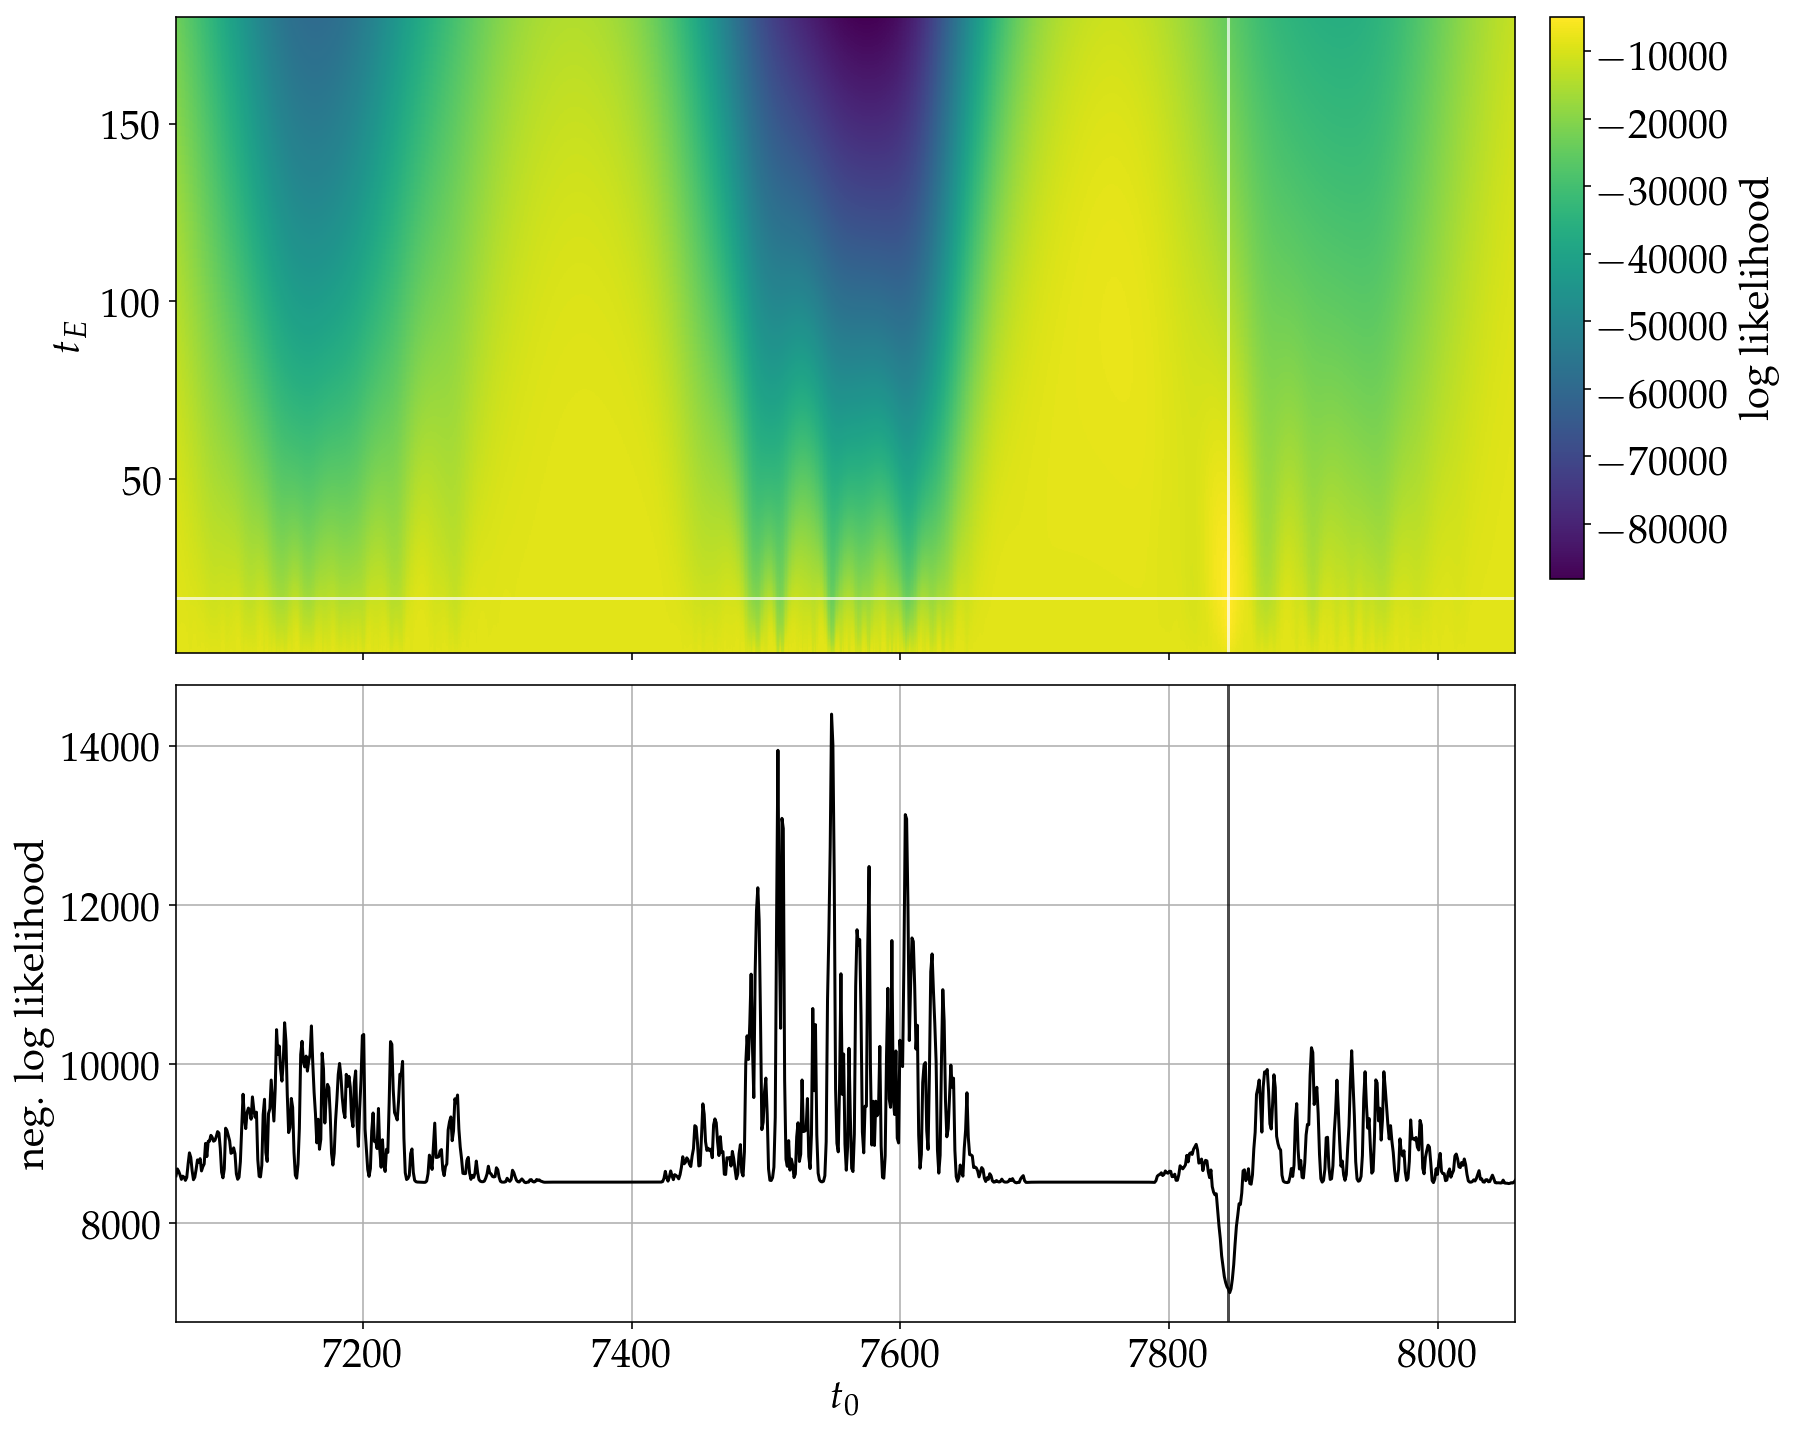

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(12,12), sharex=True)
fig.subplots_adjust(hspace=0.05)

colormap = ax[0].pcolormesh(t0_grid, tE_grid, likelihood_values)


ax[0].axhline(quantiles[1, -1], color='white', alpha=0.7)
ax[0].axvline(quantiles[1, 2], color='white', alpha=0.7)

# Find indices of median t0 and medin tE
idx_t0_median = (np.abs(t0_grid[0, :] - quantiles[1, 2] )).argmin()
idx_tE_median = (np.abs(tE_grid[:, 0] - quantiles[1, -1])).argmin()

# ax[1].plot(t0_grid[idx_tE_median, :], -likelihood_values[idx_tE_median, :], color='black')
ax[1].plot(t0_grid[10, :], -likelihood_values[10, :], color='black')

ax[1].axvline(quantiles[1, 2], color='black', alpha=0.7)
ax[1].set_xlim(t0_grid[0, 0], t0_grid[0, -1])
ax[1].grid()
ax[1].set_xlabel('$t_0$')
ax[0].set_ylabel('$t_E$')
ax[1].set_ylabel('neg. log likelihood')


cbar = plt.axes([0.92, 0.555, .02, .325])

fig.colorbar(colormap, cax=cbar, label='log likelihood')

# Likelihood surface in ($\Delta F$, $F_b$) parametrization

In [8]:
def pspl_flux2(t, pars):
        DeltaF, Fb, t0, teff, tE = pars
        
        u0 = teff/tE

        u = np.sqrt(u0**2 + ((t - t0)/tE)**2)
        A = lambda u: (u**2 + 2)/(u*np.sqrt(u**2 + 4))
    
        return DeltaF*(A(u) - 1)/(A(u0) - 1) + Fb
    
def log_likelihood2(pars):
        N = len(F)
        
        dF = F - pspl_flux2(t, pars)
    
        return np.sum(-0.5*dF**2/sigF**2)
    
def log_prior2(pars):

    DeltaF, Fb, t0, teff, tE = pars

    if DeltaF < 0 or DeltaF > 1.5*np.max(F):
        return -np.inf
    if Fb < -10 or Fb > 10:
        return -np.inf
    if t0 < np.min(t) or t0 > np.max(t): 
        return -np.inf
    if teff < 0. or teff > 50.:
        return -np.inf
    if tE < 0.5 or tE > 200.:
        return -np.inf

    return 0.

def log_posterior2(pars):
    lnp = log_prior2(pars)
    if np.isinf(lnp): # short-circuit if the prior is infinite (don't bother computing likelihood)
        return lnp

    lnL = log_likelihood2(pars)
    lnprob = lnp + lnL

    if np.isnan(lnprob):
        return -np.inf

    return lnprob

In [9]:
initial2 = [np.max(F), 0., t[t0_guess_idx], 0.5, 10.]

ndim, nwalkers = len(initial), 50
p0 = initial2 + 1e-8 * np.random.randn(nwalkers, ndim)
sampler2 = emcee.EnsembleSampler(nwalkers, ndim, log_posterior2)

print("Running burn-in...")
p0, _, _ = sampler2.run_mcmc(p0, 1000)
sampler2.reset()

print("Running production...")
sampler2.run_mcmc(p0, 5000);

Running burn-in...
Running production...


/home/fran/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/fran/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/fran/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/fran/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/fran/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] n

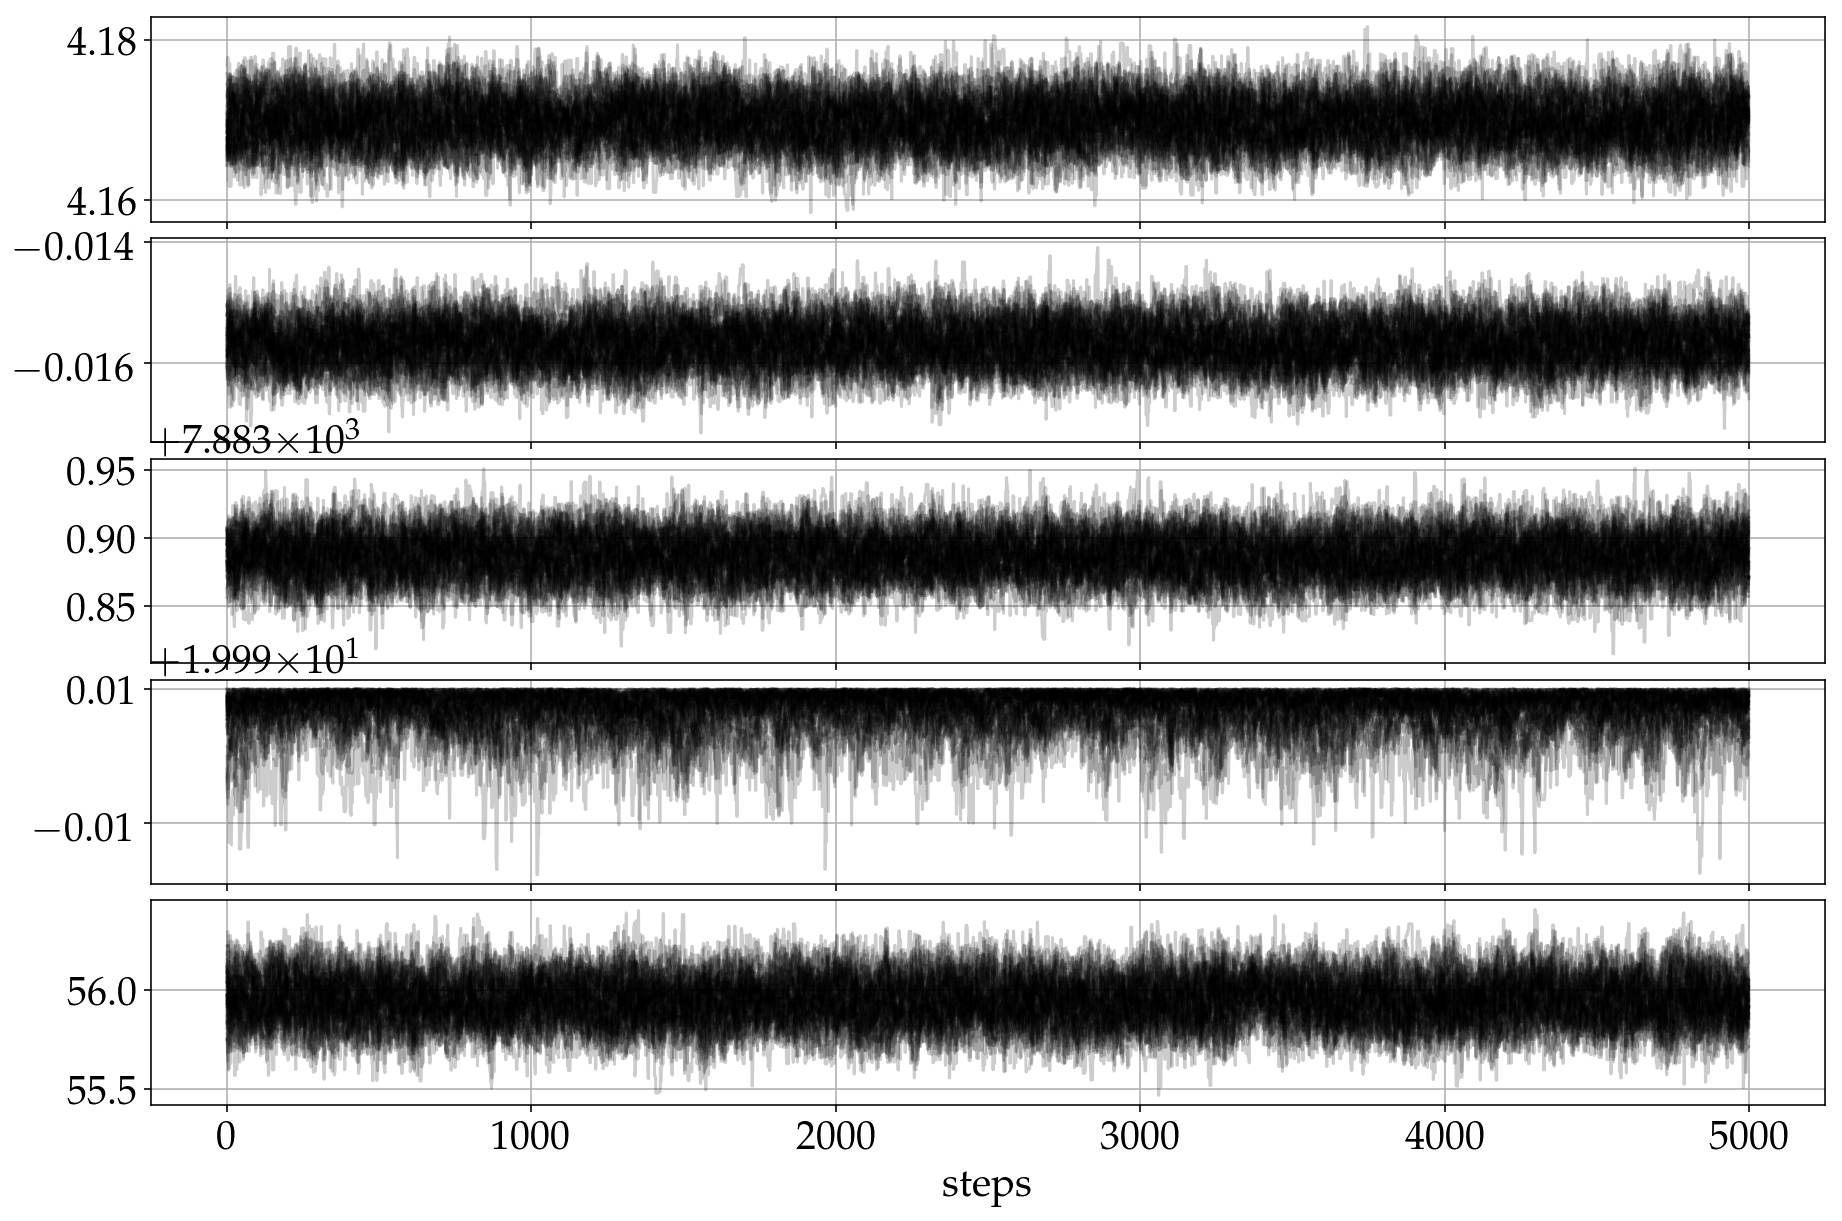

In [12]:
plot_traceplots(sampler2)

/home/fran/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


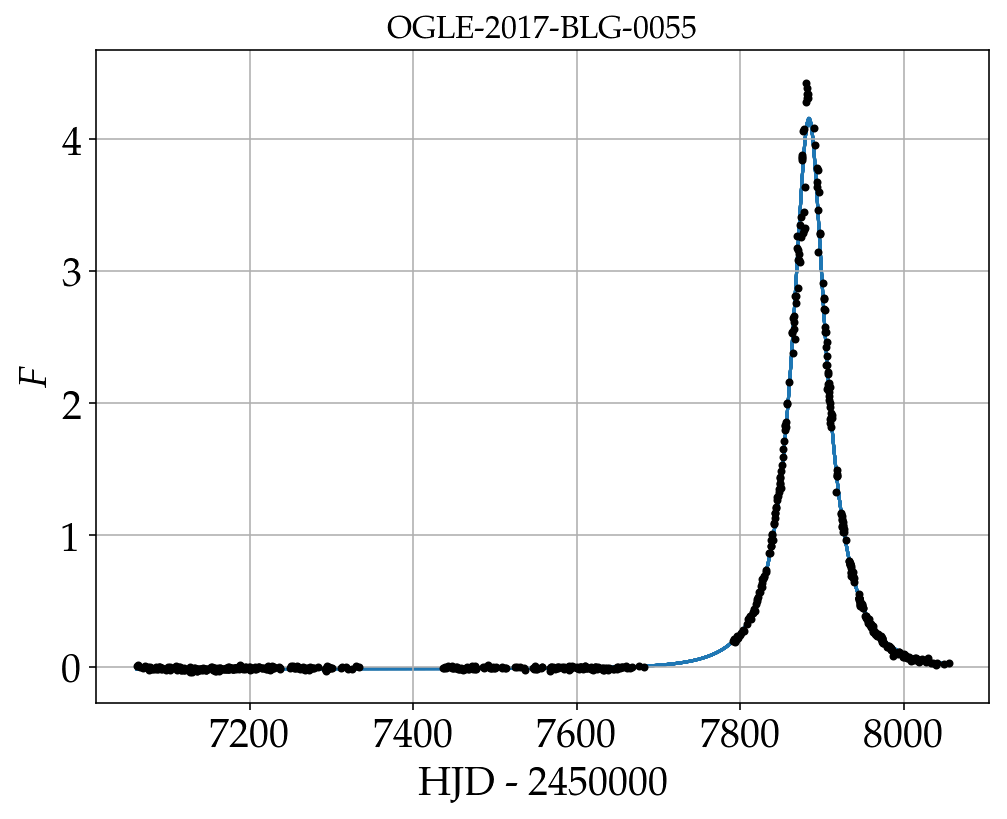

In [14]:
# Plot the data.
fig, ax = plt.subplots(figsize=(8, 6))

plot_data(ax, t, F, sigF)

t_ = np.linspace(t[0], t[-1], 1000)

samples2 = sampler2.chain[sampler2.acceptance_fraction > 0.05, 2000::1].reshape((-1, 5))
for s in samples2[np.random.randint(len(samples2), size=50)]:
#     ax.plot(t_, mu, color=color, alpha=0.3)
    ax.plot(t_, pspl_flux2(t_, s), 
             marker='', linestyle='-', color='C0', alpha=0.3, zorder=-10)

ax.grid(True)
# ax.set_xlim(7700, 8000)
# ax.set_xlim(7500, 8000)

/home/fran/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/fran/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/fran/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/fran/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


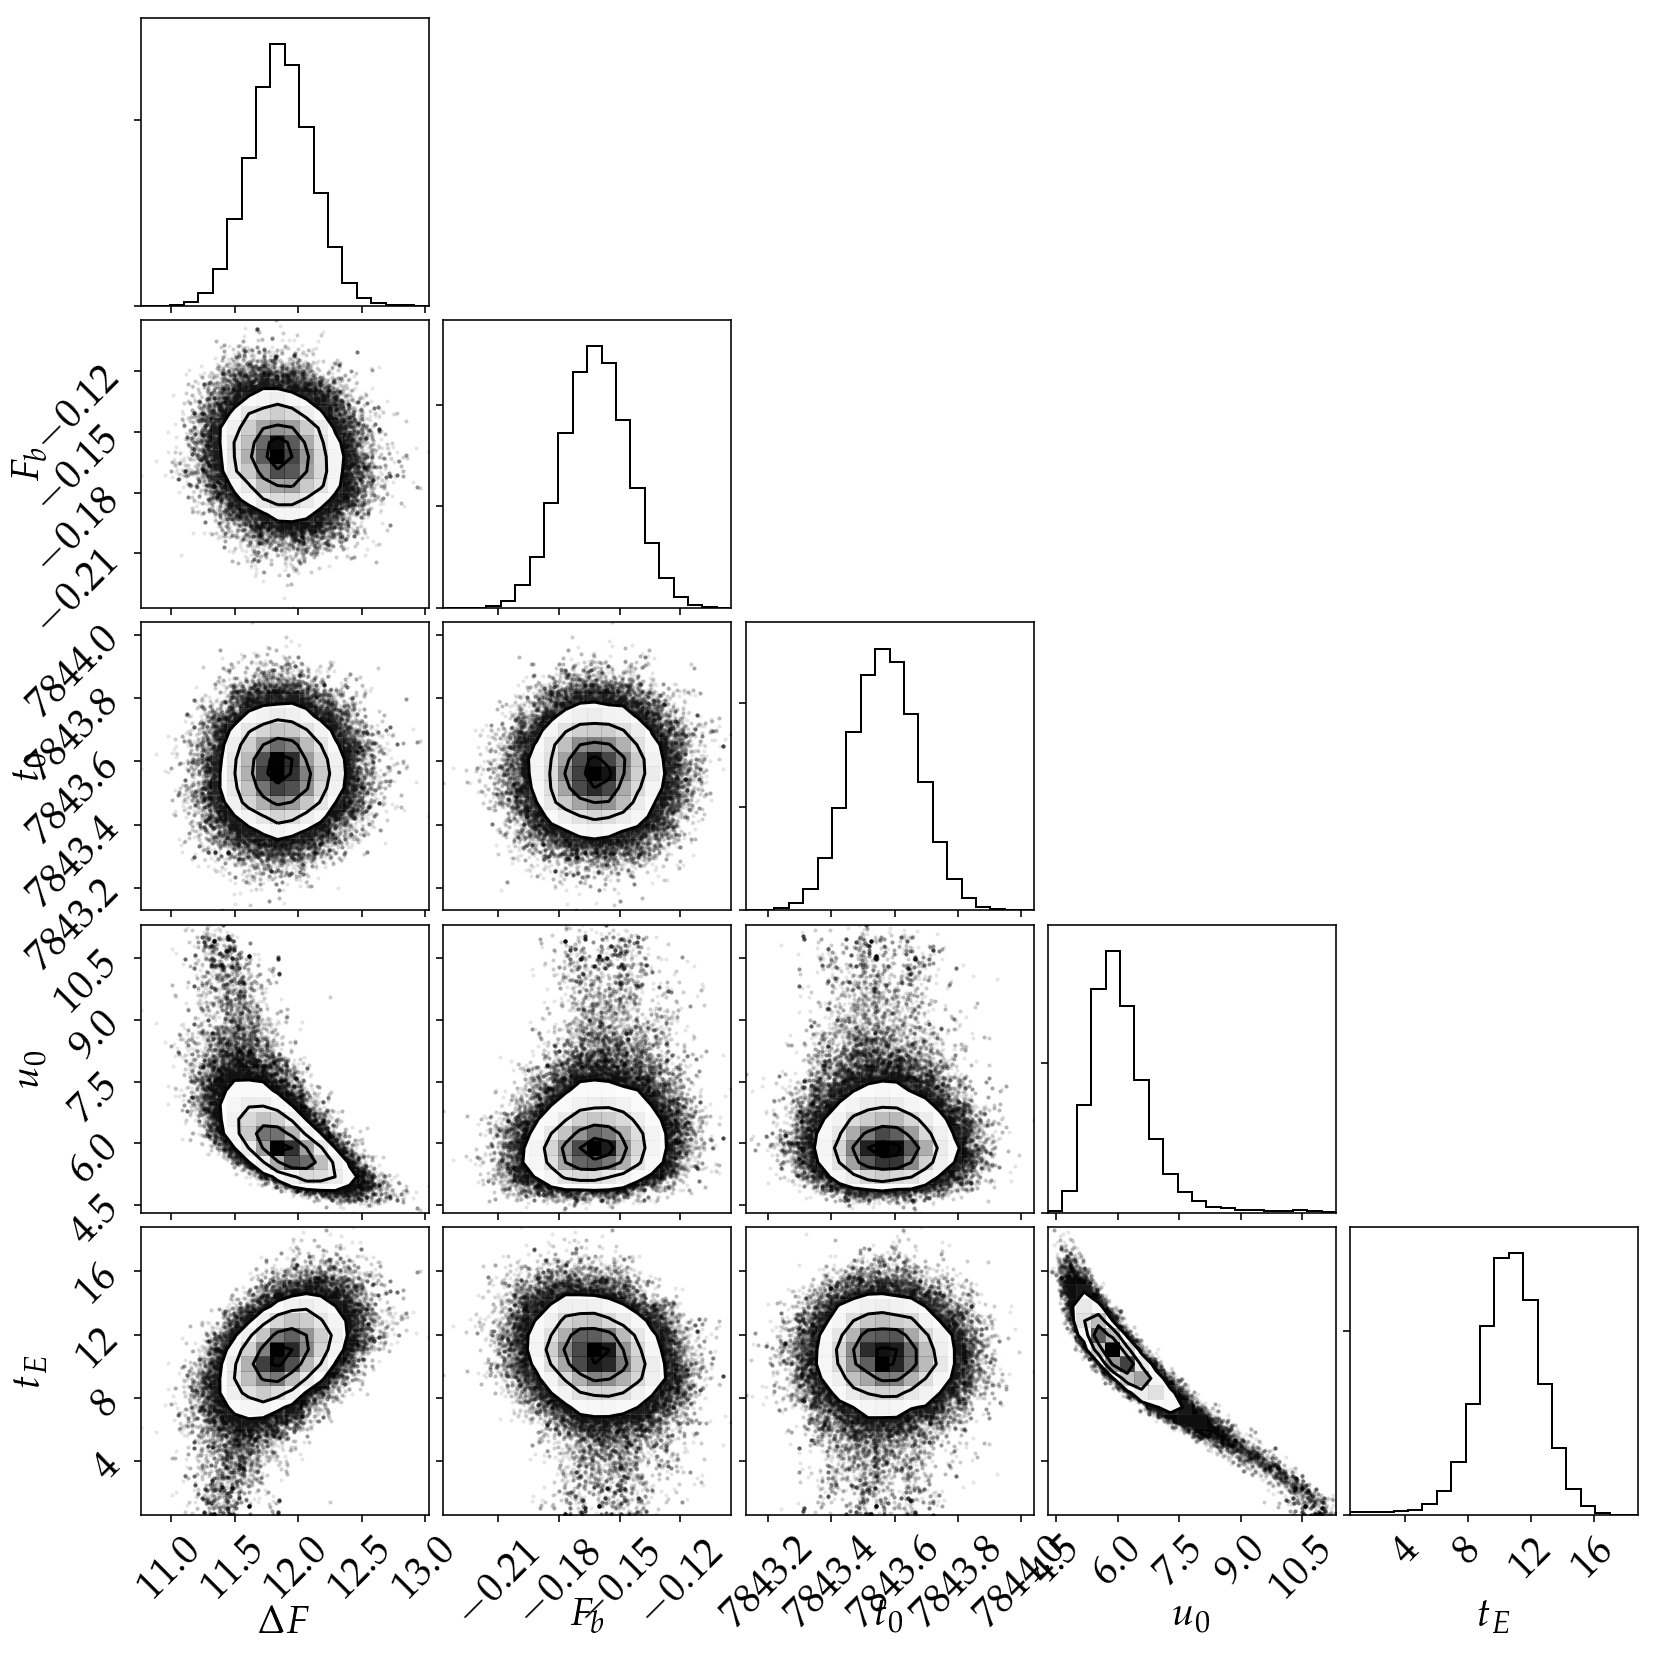

In [36]:
import corner
fig = corner.corner(samples2, labels=['$\Delta F$', '$F_b$', '$t_0$', '$u_0$', '$t_E$']);
fig.constrained_layout = True;

In [31]:
quantiles2 = np.percentile(samples2, [16, 50, 84], axis=0)
print(quantiles2[1])

[  1.22838680e+01  -1.66043797e-01   7.84357711e+03   4.90233787e+00
   1.44871443e+01]


In [16]:
# Grid of parameters in (t0, u0) subspace
likelihood_values2 = np.zeros((1000, 1000))

for i in range(1000):
    for j in range(1000):
        likelihood_values2[i, j] = log_likelihood2(
            [quantiles2[1][0], quantiles2[1][1], t0_grid[i, j], quantiles2[1][3], tE_grid[i, j]])

/home/fran/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


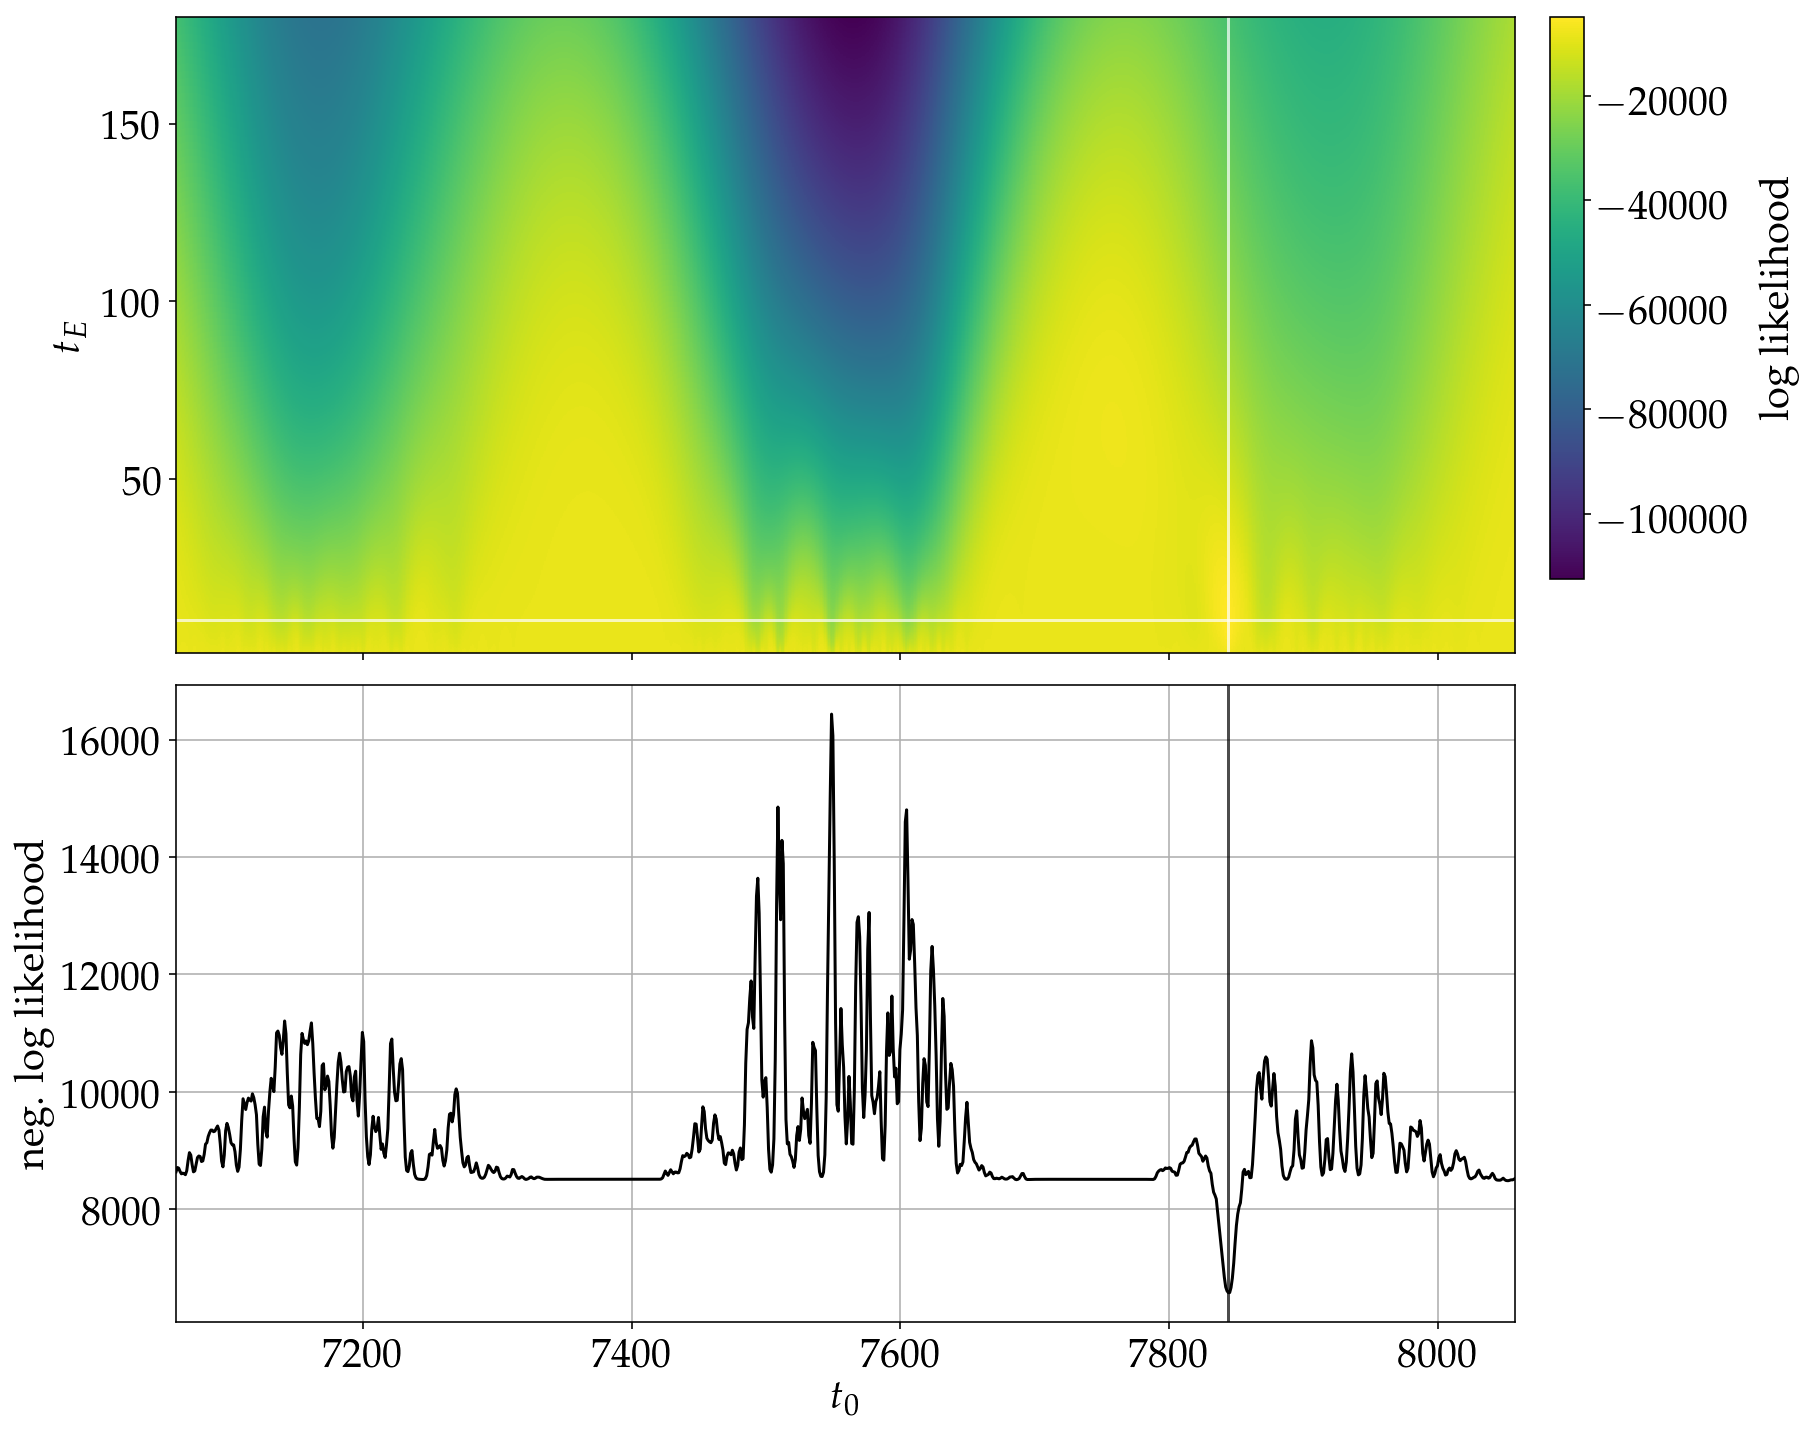

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(12,12), sharex=True)
fig.subplots_adjust(hspace=0.05)

colormap = ax[0].pcolormesh(t0_grid, tE_grid, likelihood_values2)


ax[0].axhline(quantiles2[1, -1], color='white', alpha=0.7)
ax[0].axvline(quantiles2[1, 2], color='white', alpha=0.7)

# Find indices of median t0 and medin tE
idx_t0_median = (np.abs(t0_grid[0, :] - quantiles2[1, 2] )).argmin()
idx_tE_median = (np.abs(tE_grid[:, 0] - quantiles2[1, -1])).argmin()

# ax[1].plot(t0_grid[idx_tE_median, :], -likelihood_values[idx_tE_median, :], color='black')
ax[1].plot(t0_grid[10, :], -likelihood_values2[10, :], color='black')

ax[1].axvline(quantiles2[1, 2], color='black', alpha=0.7)
ax[1].set_xlim(t0_grid[0, 0], t0_grid[0, -1])
ax[1].grid()
ax[1].set_xlabel('$t_0$')
ax[0].set_ylabel('$t_E$')
ax[1].set_ylabel('neg. log likelihood')


cbar = plt.axes([0.92, 0.555, .02, .325])

fig.colorbar(colormap, cax=cbar, label='log likelihood')

# GP model Matern 3/2 kernel

In [18]:
from celerite.modeling import Model
from celerite import terms

class PointSourcePointLensGP(Model):
    parameter_names = ("Fs", "g", "t0", "u0", "tE")

    def get_value(self, t):
        Fs = self.Fs
        g = self.g
        t0 = self.t0
        u0 = self.u0
        tE = self.tE
        
        u = np.sqrt(u0**2 + ((t - t0)/tE)**2)
            
        A = lambda u: (u**2 + 2)/(u*np.sqrt(u**2 + 4))          

        return Fs*(A(u) + g)

In [19]:
from scipy.optimize import minimize

# Set up mean model
mean_model = PointSourcePointLensGP(2., 2., 7900., 0.5, 10.)

# Set up the GP model
kernel = terms.Matern32Term(log_sigma=np.log(np.var(F)), log_rho=-np.log(10.0))
gp = celerite.GP(kernel, mean=mean_model, fit_mean=True)
gp.compute(t, sigF)
print("Initial log-likelihood: {0}".format(gp.log_likelihood(F)))

# Define a cost function
def neg_log_like(params, F, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(F)


# Fit for the maximum likelihood parameters
initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()
soln = minimize(neg_log_like, initial_params,
                method="L-BFGS-B", bounds=bounds, args=(F, gp))
gp.set_parameter_vector(soln.x)
print("Final log-likelihood: {0}".format(-soln.fun))

# Make the maximum likelihood prediction
t_ = np.linspace(data['HJD'].values[0], data['HJD'].values[-1]*1.1, 10000)
mu, var = gp.predict(F, t_, return_var=True)
std = np.sqrt(var)

# Plot data
fig, ax = plt.subplots(figsize=(14,6))
plot_data(ax,t, F, sigF)

ax.grid(True)
color = "#ff7f0e"
ax.set_xlim(7750, 8100)
plt.plot(t_, mu, color=color)
plt.fill_between(t_, mu+std, mu-std, color=color, alpha=0.3, edgecolor="none")

# plt.xlim(7900, 7910)
# plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))
# plt.title("Maximum likelihood prediction");
# plt.savefig('../report/figures/gp_max_likelihood.pdf', bbox_inches='tight')
print("Maximum likelihood parameters: ", soln.x)

Initial log-likelihood: -8004.416276262548
Final log-likelihood: -6822.370272520005


NameError: name 'data' is not defined

In [ ]:
likelihood_values_gp = np.zeros((1000, 1000))

for i in range(1000):
    for j in range(1000):
        gp.set_parameter_vector([np.log(np.var(F)),np.log(1),
                                 2.87410571e-01, 4.77494383e-01, t0_grid[i, j], 4.15041795e-01, tE_grid[i, j]])
        likelihood_values_gp[i, j] = gp.log_likelihood(F)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12,12), sharex=True)

colormap = ax[0].pcolormesh(t0_grid, tE_grid, likelihood_values_gp)


ax[0].axhline(quantiles[1, -1], color='white', alpha=0.7)
ax[0].axvline(quantiles[1, 2], color='white', alpha=0.7)

# Find indices of median t0 and medin tE
idx_t0_median = (np.abs(t0_grid[0, :] - quantiles[1, 2] )).argmin()
idx_tE_median = (np.abs(tE_grid[:, 0] - quantiles[1, -1])).argmin()

# ax[1].plot(t0_grid[idx_tE_median, :], -likelihood_values_gp[idx_tE_median, :], color='black')
ax[1].plot(t0_grid[10, :], -likelihood_values_gp[10, :], color='black')

ax[1].axvline(quantiles[1, 2], color='black', alpha=0.7)
ax[1].set_xlim(t0_grid[0, 0], t0_grid[0, -1])
ax[1].grid()
ax[1].set_xlabel('$t_0$')
ax[0].set_ylabel('$t_E$')
ax[1].set_ylabel('neg. log likelihood')


cbar = plt.axes([0.92, 0.555, .02, .325])

fig.colorbar(colormap, cax=cbar, label='log likelihood')